In [67]:
# Using Gold prices as a predictor for Bitcoin prices with a two week window uwing LSTM RNN model

In [68]:
## Data Preparation
# 1. Rolling 10 day window (ten trading days)
# 2. 70% training data 30% testing data
# 3. Use MinMaxScaler to X and y values

In [69]:
# Imports

import yfinance as yf
import numpy as np
import pandas as pd
import hvplot.pandas

In [70]:
# Setting random seed for testing - will comment out for final product

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [71]:
# Load price data for gold using yfinance

index_df = yf.download("^VIX", start='2021-01-01', end='2021-06-02')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^VIX'})
index_df = index_df['^VIX'].pct_change()
index_df = index_df.dropna()
index_df.head()

[*********************100%***********************]  1 of 1 completed


Date
2021-01-05   -0.060437
2021-01-06   -0.010655
2021-01-07   -0.107698
2021-01-08   -0.036209
2021-01-11    0.116883
Name: ^VIX, dtype: float64

In [72]:
# Load price data for Bitcoin using yfinance
stock_df = yf.download("^RUT", start='2021-01-01', end='2021-06-02')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
stock_df = stock_df['^RUT'].pct_change()
stock_df = stock_df.dropna()
stock_df.head()

[*********************100%***********************]  1 of 1 completed


Date
2021-01-05    0.017061
2021-01-06    0.039821
2021-01-07    0.018937
2021-01-08   -0.002494
2021-01-11   -0.000311
Name: ^RUT, dtype: float64

In [73]:
# Concatenate into single df

df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,^VIX,^RUT
Date,,
2021-01-05,-0.060437,0.017061
2021-01-06,-0.010655,0.039821
2021-01-07,-0.107698,0.018937
2021-01-08,-0.036209,-0.002494
2021-01-11,0.116883,-0.000311
2021-01-12,-0.031146,0.017671
2021-01-13,-0.048007,-0.007514
2021-01-14,0.046826,0.020540
2021-01-15,0.046882,-0.014916


In [74]:
# Below function takes column number for the features (X) and target (y)
# It accumulates the data with a rolling window of X(t-n) to predict Xt
# Finally, it returns a numpy array of X and y

def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    print(len(df) - window - 1)
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [75]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'index' column
# Column index 1 is the 'stock' column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

91


In [76]:
# 70% of data will be for training and 30% for testing

from sklearn.model_selection import train_test_split
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [77]:
# Scaling data between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [78]:
# Reshape the features for the model

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [79]:
## Building/training LSTM RNN

In [80]:
# Imports from tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [81]:
# LSTM Model
# How many layers are we doing? Check before doing return sequences. Set to True if adding more LSTM layers but not for final layer
# Input shape: number of time steps and number of indicators
# Dropouts to prevent overfitting
# Define the LSTM RNN model

model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer

model.add(Dense(1))

In [82]:
# Compile the model
# What is Adam?

model.compile(optimizer="adam", loss="mean_squared_error")

In [83]:
# Summarize the model

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 5)             140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [84]:
# Train the model
# Use at least 10 epochs - maybe more
# Experiement with the batch size, stick to smaller or?
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
63/63 [==============================] - 12s 13ms/step - loss: 0.2893
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0600
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0616
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0481
Epoch 5/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0495
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0648
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0536
Epoch 8/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0600ETA: 0s -
Epoch 9/10
63/63 [==============================] - 1s 16ms/step - loss: 0.0446
Epoch 10/10
63/63 [==============================] - 1s 18ms/step - loss: 0.0561


In [85]:
## Model Performance

In [86]:
# Evaluate the model

model.evaluate(X_test, y_test)

1/1 [==============================] - 4s 4s/step - loss: 0.0380


0.03796841576695442

In [87]:
# Predictions

predicted = model.predict(X_test)

In [88]:
# Recover the unscaled prices

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [89]:
# Create df of predicted and real prices

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2021-04-22,0.023499,-0.002282
2021-04-23,-0.003134,-0.002190
2021-04-26,0.017580,-0.002170
2021-04-27,0.011510,-0.002113
2021-04-28,0.001419,-0.002106


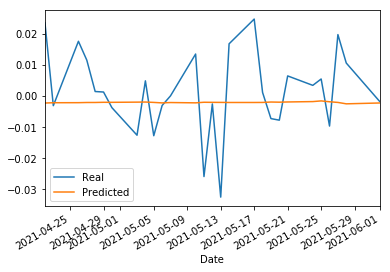

In [90]:
# Real vs predicted line plot to check fit

stocks.plot()

In [91]:
index_df = yf.download("^VIX", start='2021-01-01', end='2021-06-02')
index_df = index_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'VIX^'})
index_df.head()

[*********************100%***********************]  1 of 1 completed


,VIX^
Date,
2021-01-04,26.969999
2021-01-05,25.340000
2021-01-06,25.070000
2021-01-07,22.370001
2021-01-08,21.559999


In [92]:
stock_df = yf.download("^RUT", start='2021-01-01', end='2021-06-02')
stock_df = stock_df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns = {'Close':'^RUT'})
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,^RUT
Date,
2021-01-04,1945.910034
2021-01-05,1979.109985
2021-01-06,2057.919922
2021-01-07,2096.889893
2021-01-08,2091.659912


In [93]:
df = pd.concat([index_df, stock_df], axis="columns", join="inner")
df

,VIX^,^RUT
Date,,
2021-01-04,26.969999,1945.910034
2021-01-05,25.340000,1979.109985
2021-01-06,25.070000,2057.919922
2021-01-07,22.370001,2096.889893
2021-01-08,21.559999,2091.659912
2021-01-11,24.080000,2091.010010
2021-01-12,23.330000,2127.959961
2021-01-13,22.209999,2111.969971
2021-01-14,23.250000,2155.350098


In [94]:
correlation = df.corr()
correlation

,VIX^,^RUT
VIX^,1.000000,-0.584278
^RUT,-0.584278,1.000000
